
# Сравнение моделей, полученных в ходе поиска по сетке, с помощью статистических тестов

Этот пример показывает, как с помощью статистических тестов сравнить качество моделей, полученных в ходе поиска по сетке `sklearn.model_selection.GridSearchCV`.

Начнем с симуляции набора данных make_moons (в котором идеальное разделение между классами является нелинейным), добавив в него умеренную степень шума. Точки данных будут принадлежать одному из двух возможных классов, предсказываемым по двум признакам. Симулируем по 50 наблюдений для каждого класса:

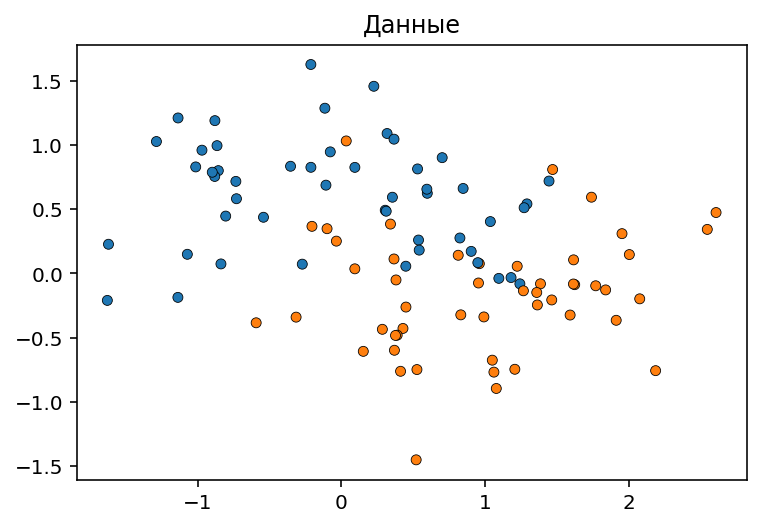

In [1]:
# импортируем библиотеки
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

# импортируем make_moons
from sklearn.datasets import make_moons

# генерируем набор
X, y = make_moons(noise=0.352, random_state=1, n_samples=100)

# строим диаграмму рассеяния
sns.scatterplot(
    x=X[:, 0], y=X[:, 1], hue=y,
    marker='o', s=25, edgecolor='k', legend=False
).set_title("Данные")
plt.show()

Сравним качество классификаторов на основе метода опорных векторов `sklearn.svm.SVC` с разными значениями параметра `kernel`, чтобы выяснить, какое значение этого гиперпараметра предсказывает наши симулированные данные лучше всего. Мы будем оценивать качество моделей, используя класс `sklearn.model_selection.RepeatedStratifiedKFold`, повторяя 10 раз 10-блочную стратифицированную перекрестную проверку, используя различную рандомизацию данных при каждом повторе. Качество модели будет оцениваться с помощью функции `sklearn.metrics.roc_auc_score`.

In [2]:
# импортируем необходимые классы
from sklearn.model_selection import (GridSearchCV, 
                                     RepeatedStratifiedKFold)
from sklearn.svm import SVC

# задаем сетку гиперпараметров
param_grid = [
    {'kernel': ['linear']},
    {'kernel': ['poly'], 'degree': [2, 3]},
    {'kernel': ['rbf']}
]

# задаем экземпляр класса SVC
svc = SVC(random_state=0)

# задаем экземпляр класса RepeatedStratifiedKFold, 
# т.е. задаем повторную стратифицированную
# перекрестную проверку
cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=10, random_state=0
)

# выполняем поиск по сетке
search = GridSearchCV(
    estimator=svc, param_grid=param_grid,
    scoring='roc_auc', cv=cv
)
search.fit(X, y);

Теперь можем посмотреть результаты нашего поиска по сетке, которые отсортированы по убыванию метрики, усредненной по тестовым блокам `mean_test_score`:

In [3]:
# импортируем pandas
import pandas as pd

# записываем результаты перекрестной
# проверки в виде датафрейма
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df['params'].apply(
        lambda x: '_'.join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)

# отбираем нужные столбцы
results_df[
    ['params', 'rank_test_score', 
     'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
rbf,{'kernel': 'rbf'},1,0.9400,0.079297
linear,{'kernel': 'linear'},2,0.9300,0.077846
3_poly,"{'degree': 3, 'kernel': 'poly'}",3,0.9044,0.098776
2_poly,"{'degree': 2, 'kernel': 'poly'}",4,0.6852,0.169106


Видно, что лучше всего cработал классификатор, использующий гауссово ядро с радиальной базовой функцией `'rbf'`, за ним следует линейное ядро `'linear'`. Обе оценки с полиномиальным ядром `'poly'` сработали хуже: та, которая использовала полином второй степени, имеет гораздо меньшее качество, чем все остальные модели.

Обычно анализ на этом просто заканчивается, но половина истории упускается. Класс `sklearn.model_selection.GridSearchCV` не дает информацию о степени уверенности в найденных различиях между моделями. Мы не знаем, являются ли различия **статистически** значимыми. Чтобы оценить это, нужно провести статистический тест. В частности, чтобы сопоставить качество двух моделей, нужно статистически сравнить их оценки AUC (площадь под ROC-кривой). У нас - 100 выборок (100 значений AUC) для каждой модели, поскольку мы повторили 10 раз 10-блочную перекрестную проверку.

Однако оценки моделей не являются независимыми: все модели оцениваются на **одних и тех же** 100 выборках, что увеличивает корреляцию между оценками качества моделей. Поскольку некоторые разбиения данных могут упростить или усложнить задачу разделения классов для всех моделей, оценки моделей будут варьировать соответствующим образом.
Поэтому полезно проверить эффект разбиения данных, построив график оценки качества всех моделей в каждом блоке и вычислим корреляцию между моделями по блокам.

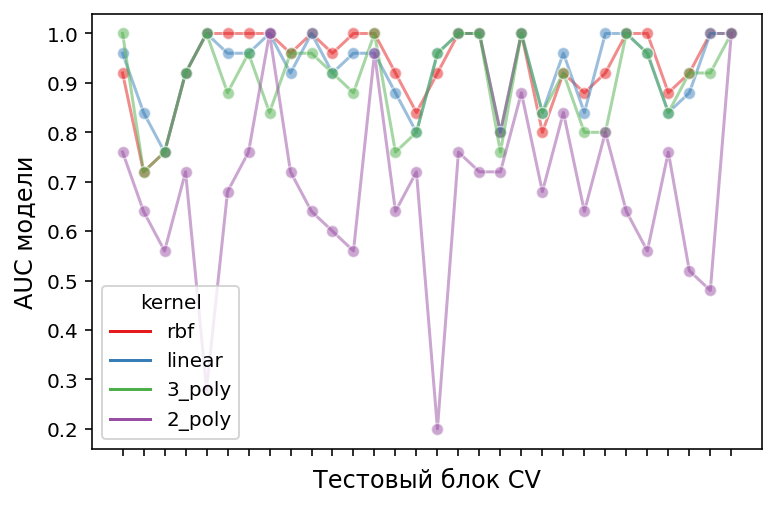

Корреляция моделей:
 kernel       rbf    linear    3_poly    2_poly
kernel                                        
rbf     1.000000  0.882561  0.783392  0.351390
linear  0.882561  1.000000  0.746492  0.298688
3_poly  0.783392  0.746492  1.000000  0.355440
2_poly  0.351390  0.298688  0.355440  1.000000


In [4]:
# создаем датафрейм с поблочными оценками модели, 
# отсортированными по убыванию качества
model_scores = results_df.filter(regex=r'split\d*_test_score')

# выводим на график 30 примеров зависимости 
# оценки AUC от блока перекрестной проверки
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("Тестовый блок CV", size=12, labelpad=10)
ax.set_ylabel("AUC модели", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# выводим корреляцию между оценками AUC в разрезе блоков
print(f"Корреляция моделей:\n {model_scores.transpose().corr()}")

Можно заметить, что качество моделей сильно зависит от блока перекрестной проверки.

Как следствие, если предположить независимость между выборками, будет недооцениваться дисперсия, вычисленная в наших статистических тестах, увеличивая количество ложноположительных ошибок (т.е. обнаруживая значительную разницу между моделями, когда таковой не существует) [1].

Для этих случаев было разработано несколько статистических тестов с поправкой на дисперсию. В этом примере мы покажем, как реализовать один из них (так называемый скорректированный t-критерий Надо-Бенжио) в соответствии с двумя разными статистическими подходами: частотным и байесовским.

## Сравнение двух моделей: частотный подход

Можно начать с вопроса: «Является ли первая модель значительно лучше, чем вторая модель (когда используется сортировка по `mean_test_score`)?"

Чтобы ответить на этот вопрос, используя частотный подход, можно было бы запустить парный t-критерий и вычислить p-значение. В литературе по прогнозированию он также известен как тест Диболда-Мариано [5]. Многие варианты такого t-критерия были разработаны для учета «проблемы независимости выборок», описанной в предыдущем разделе. Мы воспользуемся одним из вариантов t-критерия, который, как было доказано, позволяет получить максимально воспроизводимые оценки качества (он оценивает, насколько схоже качество модели при ее оценке на разных случайных выборках из одного и того же набора данных), сохраняя при этом низкий уровень как ложноположительных, так и ложноотрицательных ошибок, - скорректированным t-критерием Надо и Бенжио [2], использующим 10-повторную 10-блочную перекрестную проверку [3].

Этот скорректированный парный t-критерий рассчитывается так:

\begin{align}t=\frac{\frac{1}{k \cdot r}\sum_{i=1}^{k}\sum_{j=1}^{r}x_{ij}}
   {\sqrt{(\frac{1}{k \cdot r}+\frac{n_{test}}{n_{train}})\hat{\sigma}^2}}\end{align}


где $k$ - количество блоков, $r$ - количество повторов в перекрестной проверке, $x$ - разница в оценке качества моделей, $n_{test}$ - количество наблюдений, используемых для тестирования, $n_{train}$ - это количество наблюдений, используемых для обучения, и $\hat{\sigma}^2$ представляет собой дисперсию наблюдаемых различий.

Давайте реализуем скорректированный правосторонний парный t-критерий, чтобы оценить, значительно ли качество первой модели лучше, чем у второй модели. Наша нулевая гипотеза состоит в том, что вторая модель работает по крайней мере так же хорошо, как первая.

In [5]:
import numpy as np
from scipy.stats import t

# пишем функцию, вычисляющую знаменатель формулы
def corrected_std(differences, n_train, n_test):
    """
    Функция корректирует стандартное отклонение, 
    используя метод Надо-Бенжио.

    Параметры
    ----------
    differences : ndarray формы (n_samples, 1)
        Вектор, содержащий разности оценок 
        качества двух моделей.
    n_train : int
        Количество наблюдений в обучающей выборке.
    n_test : int
        Количество наблюдений в тестовой выборке.

    Возвращает
    -------
    corrected_std : int
        Стандартное отклонение набора различий 
        с поправкой на дисперсию.
    """
    # kr = k x r, r-повторная k-блочная перекрестная проверка,
    # kr - это сколько раз оценивалась наша модель
    kr = len(differences)
    corrected_var = (np.var(differences, ddof=1) * 
                     (1 / kr + n_test / n_train))
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

# пишем функцию, вычисляющую правосторонний парный 
# t-критерий с поправкой на дисперсию
def compute_corrected_ttest(differences, df, n_train, n_test):
    """
    Функция вычисляет правосторонний парный 
    t-критерий с поправкой на дисперсию.

    Параметры
    ----------
    differences : спископодобный объект формы (n_samples, 1)
        Вектор, содержащий разности оценок 
        качества двух моделей.
    df : int
        Количество степеней свободы.
    n_train : int
        Количество наблюдений в обучающей выборке.
    n_test : int
        Количество наблюдений в тестовой выборке.

    Возвращает
    -------
    t_stat : float
        t-статистику с поправкой на дисперсию.
    p_val : float
        p-значение с поправкой на дисперсию.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    # правосторонний t-критерий
    p_val = t.sf(np.abs(t_stat), df)
    return t_stat, p_val

In [6]:
# оценки наилучшей модели
model_1_scores = model_scores.iloc[0].values 
model_1_scores

array([0.92, 0.72, 0.76, 0.92, 1.  , 1.  , 1.  , 1.  , 0.96, 1.  , 0.96,
       1.  , 1.  , 0.92, 0.84, 0.92, 1.  , 1.  , 0.8 , 1.  , 0.8 , 0.92,
       0.88, 0.92, 1.  , 1.  , 0.88, 0.92, 1.  , 1.  , 0.8 , 0.96, 0.84,
       1.  , 1.  , 1.  , 1.  , 0.96, 0.92, 1.  , 1.  , 0.92, 1.  , 0.92,
       1.  , 0.76, 1.  , 1.  , 1.  , 1.  , 1.  , 0.84, 1.  , 1.  , 1.  ,
       0.72, 0.92, 1.  , 1.  , 1.  , 0.92, 0.92, 1.  , 1.  , 0.8 , 0.88,
       1.  , 0.92, 0.96, 1.  , 0.96, 0.92, 0.84, 0.92, 1.  , 1.  , 1.  ,
       0.88, 0.92, 0.92, 1.  , 0.92, 0.96, 1.  , 0.72, 1.  , 1.  , 1.  ,
       1.  , 0.76, 0.96, 0.88, 1.  , 0.72, 0.92, 1.  , 0.96, 1.  , 1.  ,
       0.84])

In [7]:
# оценки второй по качеству модели
model_2_scores = model_scores.iloc[1].values
model_2_scores

array([0.96, 0.84, 0.76, 0.92, 1.  , 0.96, 0.96, 1.  , 0.92, 1.  , 0.92,
       0.96, 0.96, 0.88, 0.8 , 0.96, 1.  , 1.  , 0.8 , 1.  , 0.84, 0.96,
       0.84, 1.  , 1.  , 0.96, 0.84, 0.88, 1.  , 1.  , 0.84, 0.92, 0.84,
       1.  , 0.96, 1.  , 1.  , 0.92, 0.88, 1.  , 0.96, 0.92, 1.  , 0.92,
       1.  , 0.76, 1.  , 0.92, 1.  , 1.  , 1.  , 0.8 , 0.96, 0.96, 1.  ,
       0.68, 0.96, 0.92, 1.  , 1.  , 0.92, 0.92, 1.  , 0.8 , 0.84, 0.88,
       0.96, 0.92, 0.96, 1.  , 0.96, 0.88, 0.8 , 0.84, 1.  , 0.96, 1.  ,
       0.92, 0.92, 0.92, 0.96, 1.  , 0.92, 1.  , 0.68, 1.  , 1.  , 1.  ,
       1.  , 0.76, 0.96, 0.92, 1.  , 0.76, 0.92, 1.  , 0.92, 0.92, 1.  ,
       0.84])

In [8]:
# вычисляем разности между оценками
differences = model_1_scores - model_2_scores

In [9]:
# количество разностей, по сути количество полученных 
# оценок качества или количество тестовых выборок
# перекрестной проверки
n = differences.shape[0]  
n

100

In [10]:
# количество степеней свободы
df = n - 1
df

99

In [11]:
# количество наблюдений, используемых для обучения
n_train = len(list(cv.split(X, y))[0][0])
n_train

90

In [12]:
# количество наблюдений, используемых для тестирования
n_test = len(list(cv.split(X, y))[0][1])
n_test

10

In [13]:
# вычисляем значение скорректированного 
# t-критерия и p-значение для него
t_stat, p_val = compute_corrected_ttest(differences, 
                                        df, 
                                        n_train, 
                                        n_test)

print(f"Значение скорректированного t-критерия: {t_stat:.3f}\n"
      f"p-значение для скорректированного t-критерия: {p_val:.3f}")

Значение скорректированного t-критерия: 0.750
p-значение для скорректированного t-критерия: 0.227


Можем сравнить значение скорректированного t-критерия и p-значение для него со значением нескорректированного t-критерия и соответствующим p-значением.

In [14]:
# вычисляем значение нескорректированного 
# t-критерия и p-значение для него
t_stat_uncorrected = (
    np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(f"Значение нескорректированного " 
      f"t-критерия: {t_stat_uncorrected:.3f}\n"
      f"p-значение для нескорректированного "
      f"t-критерия: {p_val_uncorrected:.3f}")

Значение нескорректированного t-критерия: 2.611
p-значение для нескорректированного t-критерия: 0.005


Используя общепринятый уровень значимости `p=0.05`, наблюдаем, что нескорректированный t-критерий позволяет сделать вывод о том, что первая модель значительно лучше, чем вторая.

Напротив, при использовании скорректированного подхода эта разница не обнаруживается.

Однако в последнем случае частотный подход не позволяет сделать вывод, что первая и вторая модели имеют одинаковое качество. Если мы хотим сделать подобное утверждение, нам нужно использовать байесовский подход.

## Сравнение двух моделей: байесовский подход

Мы можем воспользоваться байесовской оценкой для вычисления вероятности того, что первая модель лучше второй. Байесовская оценка даст распределение, которому подчиняется среднее значение $\mu$ разницы метрик двух моделей.

Чтобы получить апостериорное распределение, нужно сперва определить априорное, моделирующее наши представления о распределении среднего значения перед анализом данных, и умножить его на функцию правдоподобия, которая вычисляет, насколько вероятны наши наблюдаемые различия с учетом значений, которые могло бы принять среднее различий.

Чтобы ответить на вопрос, байесовское оценивание может быть выполнено в разных вариантах, но в этом примере мы реализуем подход, предложенный Бенаволи и его коллегами [4].

Один из способов определения нашего апостериорного распределения в замкнутой форме - выбрать априорное распределение, сопряженное с функцией правдоподобия. Бенаволи и его коллеги [4] пришли к выводу, что при сравнении качества двух классификаторов мы можем моделировать априорное распределение как нормальное гамма-распределение (с неизвестными средним значением и дисперсией), сопряженное с функцией правдоподобия для нормального распределения, чтобы, таким образом, выразить апостериорное распределение как нормальное распределение.
Отбросив дисперсию из этого нормального апостериорного распределения, мы можем определить апостериорное распределение среднего как t-распределение Стьюдента. В частности:

\begin{align}St(\mu;n-1,\overline{x},(\frac{1}{n}+\frac{n_{test}}{n_{train}})
   \hat{\sigma}^2)\end{align}

где $n$ - общее количество наблюдений, $\overline{x}$ - средняя разница оценок, $n_{test}$ - количество наблюдений, использованных для тестирования, $n_{train}$ - это количество наблюдений, используемых для обучения, а $\hat{\sigma}^2$ представляет собой дисперсию наблюдаемых различий.

Обратите внимание, что в байесовском подходе также используется дисперсия, скорректированная по методу Надо-Бенжио.

Давайте вычислим и визуализируем апостериорное распределение:

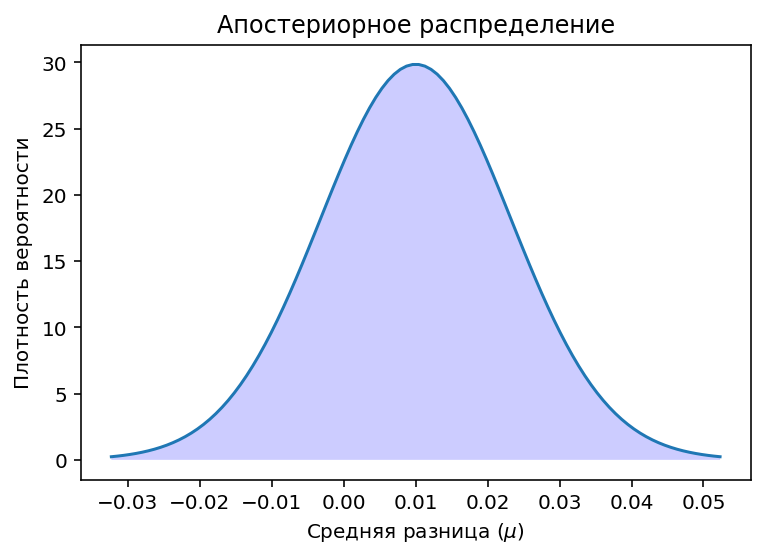

In [15]:
# получим и визуализируем апостериорное распределение

# инициализируем случайную величину
t_post = t(
    df, loc=np.mean(differences),
    scale=corrected_std(differences, n_train, n_test)
)
# с помощью квантильной функции получаем значения,
# соответствующие вероятностям распределения
x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)
# строим график функции плотности вероятности
plt.plot(x, t_post.pdf(x))
# задаем диапазон значений и цену деления для оси X,
# диапазон определяем по первому и последнему значениям
# массива, полученного с помощью квантильной функции
plt.xticks(np.arange(-0.04, 0.06, 0.01))
# визуализируем площадь под кривой распределения
plt.fill_between(x, t_post.pdf(x), 0, facecolor='blue', alpha=.2)
plt.ylabel("Плотность вероятности")
plt.xlabel(r"Средняя разница ($\mu$)")
plt.title("Апостериорное распределение")

plt.show()

Можно вычислить вероятность того, что первая модель лучше, чем вторая, вычислив площадь под кривой апостериорного распределения от нуля до бесконечности. И, наоборот, мы можем вычислить вероятность того, что вторая модель лучше первой, вычислив площадь под кривой от минус бесконечности до нуля.

In [16]:
# вычисляем вероятность того, что 
# первая модель лучше второй
better_prob = 1 - t_post.cdf(0)

print(f"Вероятность того, что {model_scores.index[0]} "
      f"имеет более высокое качество, чем " 
      f"{model_scores.index[1]}: {better_prob:.3f}")
print(f"Вероятность того, что {model_scores.index[1]} "
      f"имеет более высокое качество, чем "
      f"{model_scores.index[0]}: {1 - better_prob:.3f}")

Вероятность того, что rbf имеет более высокое качество, чем linear: 0.773
Вероятность того, что linear имеет более высокое качество, чем rbf: 0.227


В отличие от частотного подхода мы смогли вычислить вероятность того, что одна модель лучше другой.

Обратите внимание, что мы получили те же результаты, что и при частотном подходе: первая модель лучше, чем вторая. Учитывая наш выбор априорных распределений, мы по сути выполняем одни и те же вычисления, но можем cделать разные выводы.

### Область практической эквивалентности (Region of Practical Equivalence)

Иногда нас интересует определение вероятностей того, что сравниваемые модели будут иметь эквивалентное качество, где понятие «эквивалентности» определяется практическим способом. Наивный подход [4] состоял бы в том, чтобы определять классификаторы как практически эквивалентные, если они отличаются друга от друга менее чем на 1% с точки зрения метрики качества. Но мы  можем также определить эту практическую эквивалентность с точки зрения решаемой проблемы. Например, разница в метрике качества, равная 5%, будет означать увеличение продаж на 1000 долларов, и мы считаем любую величину выше этого значения значимым для нашего бизнеса.

В этом примере мы собираемся определить область практической эквивалентности (Region of Practical Equivalence - ROPE) как $[-0.01, 0.01]$. Таким образом, мы будем считать две модели практически эквивалентными, если они отличаются по своему качеству менее чем на 1%.

Чтобы вычислить вероятности того, что классификаторы будут практически эквивалентными, вычислим площадь под кривой апостериорного распределения на ROPE-интервале.
Задаем ROPE-интервал, вычисляем вероятность эквивалентности моделей с учетом заданного ROPE-интервала и визуализируем апостериорное распределение на ROPE-интервале.

In [17]:
# задаем ROPE-интервал
rope_interval = [-0.01, 0.01]
# вычисляем вероятность эквивалентности моделей
# с учетом заданного ROPE-интервала
rope_prob = (t_post.cdf(rope_interval[1]) - 
             t_post.cdf(rope_interval[0]))

print(f"Вероятность того, что {model_scores.index[0]} " 
      f"и {model_scores.index[1]} практически "
      f"эквивалентны: {rope_prob:.3f}")

Вероятность того, что rbf и linear практически эквивалентны: 0.432


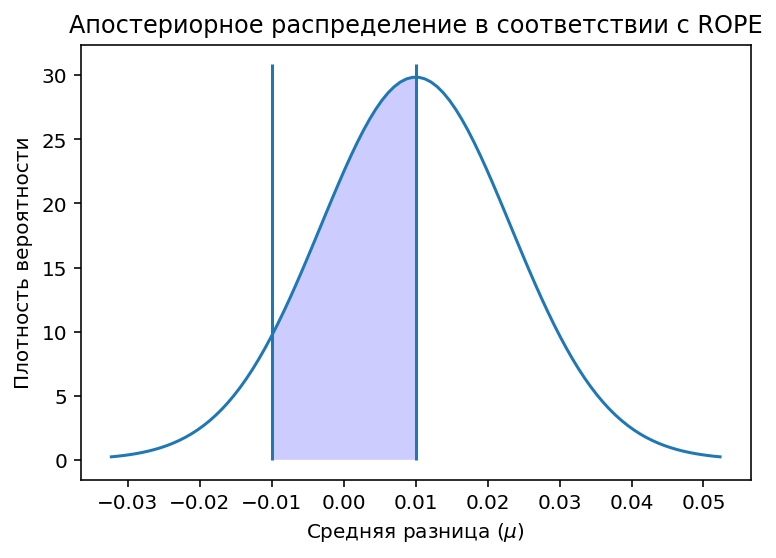

In [18]:
# получаем массив значений в заданном интервале
x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

# визуализируем апостериорное распределение 
# в соответствии с ROPE
plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.vlines([-0.01, 0.01], ymin=0, 
           ymax=(np.max(t_post.pdf(x)) + 1))
plt.fill_between(x_rope, t_post.pdf(x_rope), 0, 
                 facecolor='blue', alpha=.2)
plt.ylabel("Плотность вероятности")
plt.xlabel(r"Средняя разница ($\mu$)")
plt.title("Апостериорное распределение в соответствии с ROPE")
plt.show()

Как было предложено в [4], мы можем дополнительно интерпретировать эти вероятности, используя те же самые критерии, что и в частотном подходе: вероятность попадания в ROPE-интервал выше 95% (уровень значимости 5%)? В таком случае мы можем сделать вывод, что обе модели практически эквивалентны.
Байесовский подход к оценке также позволяет вычислить степень неопределенности нашей оценки разности метрик. Ее можно рассчитать с помощью байесовских доверительных интервалов (credible intervals). Для заданной вероятности они показывают диапазон значений, которые может принимать оцениваемая величина, в нашем случае речь идет о средней разнице между метриками качества моделей. Например, 50%-ный байесовский доверительный интервал [x, y] говорит, что существует 50%-ная вероятность того, что истинная (средняя) разница в качестве моделей находится между x и y.

Давайте определим байесовские доверительные интервалы наших данных, используя 50%, 75% и 95%:

In [19]:
# задаем пустой список, в который будем добавлять
# байесовские доверительные интервалы - списки
# из нижнего и верхнего значений
cred_intervals = []
# задаем список значений
intervals = [0.5, 0.75, 0.95]

# заполняем список
for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

# на основе полученных результатов создаем датафрейм
cred_int_df = pd.DataFrame(
    cred_intervals,
    columns=['интервал', 'нижнее значение', 'верхнее значение']
).set_index('интервал')
cred_int_df

,нижнее значение,верхнее значение
интервал,,
0.50,0.000977,0.019023
0.75,-0.005422,0.025422
0.95,-0.016445,0.036445


Как показано в таблице, существует 50%-ная вероятность того, что истинная средняя разница в качестве моделей будет между 0.000977 и 0.019023, 70%-ная вероятность того, что она будет между -0.005422 и 0.025422, и 95%-ная вероятность того, что она будет между -0.016445 и 0.036445.

## Попарное сравнение всех моделей: частотный подход

Кроме того, нас могло бы заинтересовать сравнение качества всех наших моделей, оцененных с помощью класса `sklearn.model_selection.GridSearchCV`. В этом случае мы будем проводить статистический тест несколько раз, что приведет нас к `проблеме множественных сравнений <https://en.wikipedia.org/wiki/Multiple_comparisons_problem>`.

Есть много возможных способов решения этой проблемы, но стандартный подход заключается в применении `поправки Бонферрони <https://en.wikipedia.org/wiki/Bonferroni_correction>`. Поправку Бонферрони можно вычислить, умножив p-значение на количество тестируемых сравнений.

Давайте выполним попарное сравнение всех моделей с помощью скорректированного t-критерия на основе частотного подхода:

In [20]:
# импортируем функции combinations() и factorial()
from itertools import combinations
from math import factorial

# количество сравнений
n_comparisons = (
    factorial(len(model_scores))
    / (factorial(2) * factorial(len(model_scores) - 2))
)

# список, в который будем записывать
# результаты парного t-теста
pairwise_t_test = []

# по каждой комбинации
for model_i, model_k in combinations(range(len(model_scores)), 2):
    # получаем оценки первой модели
    model_i_scores = model_scores.iloc[model_i].values
    # получаем оценки второй модели
    model_k_scores = model_scores.iloc[model_k].values
    # вычисляем разности
    differences = model_i_scores - model_k_scores
    # вычисляем скорректированный парный t-тест
    t_stat, p_val = compute_corrected_ttest(
        differences, df, n_train, n_test
    )
    # задаем поправку Бонферрони
    p_val *= n_comparisons
    # поправка Бонферрони может выдавать p-значения большие, чем 1,
    # оговариваем, что максимальное p-значение не должно превышать 1
    p_val = 1 if p_val > 1 else p_val
    # добавляем результаты  скорректированного парного 
    # t-теста с поправкой Бонферрони в список
    pairwise_t_test.append(
        [model_scores.index[model_i], model_scores.index[model_k],
         t_stat, p_val]
    )

# на основе полученных результатов создаем датафрейм
pairwise_comp_df = pd.DataFrame(
    pairwise_t_test,
    columns=['model_1', 'model_2', 't_stat', 'p_val']
).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,rbf,linear,0.750,1.000
1,rbf,3_poly,1.657,0.302
2,rbf,2_poly,4.565,0.000
3,linear,3_poly,1.111,0.807
4,linear,2_poly,4.276,0.000
5,3_poly,2_poly,3.851,0.001


Видно, что после корректировки множественных сравнений единственная модель, которая значительно отличается от других - это `'2_poly'`. Модель `'rbf'`, занимающая первое место по итогам поиска по сетке `sklearn.model_selection.GridSearchCV`, существенно не отличается от `'linear'` или `'3_poly'`.

## Попарное сравнение всех моделей: байесовский подход

При использовании байесовской оценки для сравнения нескольких моделей нам не нужно вводить поправку на множественные сравнения (по причинам, указанным в [4]).

In [21]:
# создаем пустой список, в который будем записывать результаты
# попарного сравнения согласно байесовскому подходу
pairwise_bayesian = []

# по каждой комбинации
for model_i, model_k in combinations(range(len(model_scores)), 2):
    # получаем оценки первой модели
    model_i_scores = model_scores.iloc[model_i].values
    # получаем оценки второй модели
    model_k_scores = model_scores.iloc[model_k].values
    # вычисляем разности
    differences = model_i_scores - model_k_scores
    # инициализируем случайную величину
    t_post = t(
        df, loc=np.mean(differences),
        scale=corrected_std(differences, n_train, n_test)
    )
    # вычисляем вероятность того, что первая модель хуже второй
    worse_prob = t_post.cdf(rope_interval[0])
    # вычисляем вероятность того, что первая модель лучше второй
    better_prob = 1 - t_post.cdf(rope_interval[1])
    # вычисляем вероятность эквивалентности моделей
    # с учетом заданного ROPE-интервала
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    # добавляем результаты в список
    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

# на основе полученных результатов создаем датафрейм
pairwise_bayesian_df = (pd.DataFrame(
    pairwise_bayesian,
    columns=['worse_prob', 'better_prob', 'rope_prob']
).round(3))

# присоединяем к датафрейму с результатами попарного сравнения 
# моделей на основе частотного подхода датафрейм с результатами 
# попарного сравнения моделей на основе байесовского подхода
pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
pairwise_comp_df

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,rbf,linear,0.750,1.000,0.068,0.500,0.432
1,rbf,3_poly,1.657,0.302,0.018,0.882,0.100
2,rbf,2_poly,4.565,0.000,0.000,1.000,0.000
3,linear,3_poly,1.111,0.807,0.063,0.750,0.187
4,linear,2_poly,4.276,0.000,0.000,1.000,0.000
5,3_poly,2_poly,3.851,0.001,0.000,1.000,0.000


Используя байесовский подход, можно вычислить вероятность того, что модель работает лучше, хуже или практически эквивалентна другой модели.

Вероятность того, что модель `'rbf'`, занявшая первое место по результатам `sklearn.model_selection.GridSearchCV`, хуже, чем `'linear'`, составляет 6.8%. Вероятность того, что модель `'rbf'` хуже, чем `'3_poly'`, составляет 1.8%. Вероятность того, что `'rbf'` и `'linear'` практически эквивалентны, составляет 43%, в то время как вероятность того, что `'rbf'` и `'3_poly'` практически эквивалентны, составляет всего 10%.

Подобно выводам, полученным с использованием частотного подхода, все модели имеют 100%-ную вероятность быть лучше, чем `'2_poly'`, и ни одна из них не имеет практической эквивалентности с последней по качеству.

## Итоговые выводы
- Небольшие различия в оценках качества могут легко оказаться просто случайностью, но не потому, что одна модель систематически предсказывает лучше, чем другая. Как показано в этом примере, статистика может сказать, насколько это вероятно.
- При статистическом сравнении качества двух моделей, оцененных в ходе поиска по сетке с помощью класса `GridSearchCV`, необходимо скорректировать вычисленную дисперсию, которая может быть недооценена, поскольку оценки моделей не являются независимыми друг от друга.
- Частотный подход, в котором используется парный t-критерий (с поправкой на дисперсию), поможет выяснить, лучше ли качество одной модели по сравнению с другой, со степенью уверенности выше случайного угадывания.
- Байесовский подход позволяет вычислить вероятности того, что одна модель будет лучше, хуже или практически эквивалентна другой. Он также позволяет сказать, какова уверенность в том, что истинная разница в качестве наших моделей попадает в определенный диапазон значений.
- Если несколько моделей сравниваются статистически, требуется корректировка множественных сравнений при использовании частотного подхода.